This is still very much a work in progress. Matrix in question is
$$ A =\begin{bmatrix}0.259 &  0.966 \\  0.966 & -0.259 \end{bmatrix} $$


In [1]:
import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

from collections import namedtuple
from qiskit import QuantumProgram
from qiskit.tools.visualization import *
import Qconfig


qasm = 'local_qasm_simulator'
usim = 'local_unitary_simulator'
qx2 = 'ibmqx2'
qx4 = 'ibmqx4'
qx5 = 'ibmqx5'
qxsim = 'ibmqx_qasm_simulator'

PhaseEstimate = namedtuple('trial','cname m result outcome')

phase_f = lambda k,l: -l*np.pi/2**k if l > 0 else -np.pi/2**(k-1)

In [2]:
Q = QuantumProgram()
Q.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
conf = Q.get_backend_configuration(backend=qx4)
cmap = conf["coupling_map"]

In [12]:
def cu_phase(q,c,t,theta):

#     q.u1(-theta,t)
    q.u3(-theta,0,0,t)
    q.z(t)
    q.cx(c,t)
    q.u3(theta,0,0,t)
    q.z(t)
#     q. u1(theta,t)
    q.cx(c,t)
    
def proc(outcome,cn, res,first=False, last=False):
    count = res.get_counts(cn)
#     if first and max(count,key=count.get) == 0:
#         return outcome 
    outcome[1]+="".join(str(max(count,key=count.get)))
    outcome[0] = int(outcome[1][::-1],2)
    if last:
        outcome[1]= outcome[1][::-1]
        print("last")
    print(outcome[0],outcome[1])
    return outcome 

def get_phase(outcome,m):
    phase = [0]*2
    eig = outcome[0] /2**m
    phi = outcome[0] / 2**(m)
    phase[0] = np.exp(1j*2*np.pi*phi)
    phase[1] = np.exp(-1j*2*np.pi*phi)
    print("Phase: ", phase)
    print("Eigenvalue: ", eig)
    return phase

In [4]:
def phase_estimate(c_name, q, c, m, n, outcome,theta):
    phase = Q.create_circuit(c_name, [q], [c])
    phase.h(q[0])
    phase.h(q[1])
    for k in range(2**(m-1-n)):
        cu_phase(phase,q[0],q[1],theta)
    if n > 0: 
        phase.u1(phase_f(n,outcome[0]), q[0])
    phase.h(q[0])

    phase.measure(q[0],c[0])
    
    r = Q.execute(c_name,
                  backend=qasm, 
                  shots=1024, 
                  silent=False,
                  wait=10,
                  timeout=440)
    outcome = proc(outcome, c_name, r,first=True if n==0 else False, last=True if m-n==1 else False)
    return PhaseEstimate(cname=c_name, m=m, result=r, outcome=outcome)

In [5]:
theta = 5*np.pi/6
m = 2
n = 0

gates = lambda q,c,t,theta: [ q.u3(theta,t), q.z(t) ]

q = Q.create_quantum_register("q", 2)
c = Q.create_classical_register("c", 1)
cname = ['phase4','phase3','phase2','phase1']

runs = []
for k in range(m):
    if k == 0:
        runs.append(phase_estimate(("phase%d" %(m-k)), q, c,m,n, [0,""], theta))
    else:
        runs.append(phase_estimate(("phase%d" %(m-k)), q, c,m,n+k, runs[-1].outcome, theta))

running on backend: local_qasm_simulator
0 0
running on backend: local_qasm_simulator
last
2 10


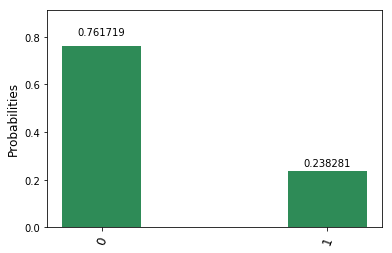

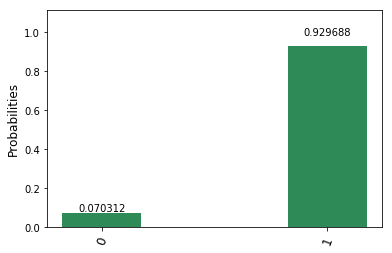

Phase:  [(-1+1.2246467991473532e-16j), (-1-1.2246467991473532e-16j)]
Eigenvalue:  0.5


In [13]:
for res in runs:
    plot_histogram(res.result.get_counts(res.cname))
p = get_phase(runs[-1].outcome,m)
eig = runs[-1].outcome[0]

In [19]:
theta1 = 2*np.arcsin(1/eig); theta1

1.0471975511965979

In [20]:
# theta2 = np.pi
Q = QuantumProgram()
Q.set_api(Qconfig.APItoken, Qconfig.config["url"])
q = Q.create_quantum_register("q", 3)
c = Q.create_classical_register("c", 3)

running on backend: local_qasm_simulator


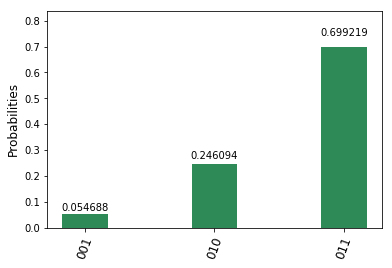

In [32]:
lse = Q.create_circuit("lse", [q], [c])

lse.x(q[0])

# lse.h(q[1])
lse.u3(5*np.pi/6,0,0,q[1])
lse.z(q[1])
# lse.cx(q[1],q[0])
lse.cu3(theta1,0,0,q[1],q[0])

lse.measure(q[0],c[0])
lse.measure(q[1],c[1])
# lse.measure(q[2],c[2])
            
r = Q.execute("lse",
              backend=qasm, 
              shots=1024, 
              silent=False,
              wait=10,
              timeout=480)

plot_histogram(r.get_counts("lse"))